In [1]:
!pip install xgboost

In [2]:
# df.head()


First 5 rows of the dataset:
   type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     1            7.0              0.27         0.36            20.7   
1     1            6.3              0.30         0.34             1.6   
2     1            8.1              0.28         0.40             6.9   
3     1            7.2              0.23         0.32             8.5   
4     1            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5

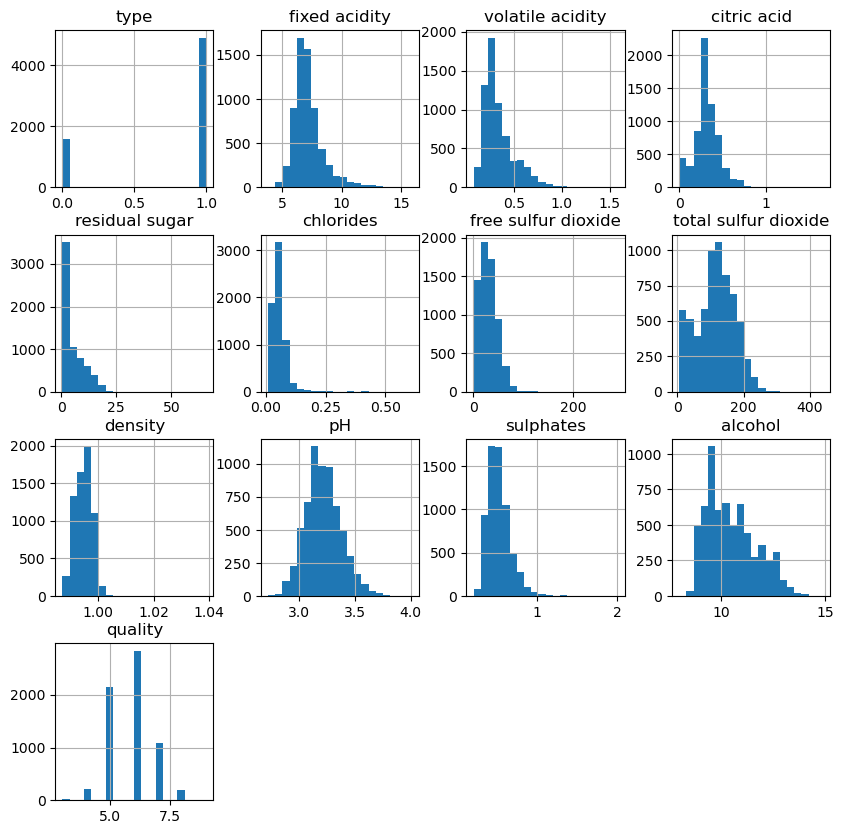

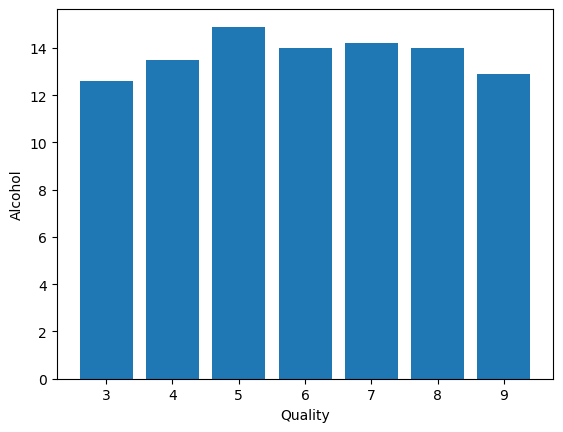

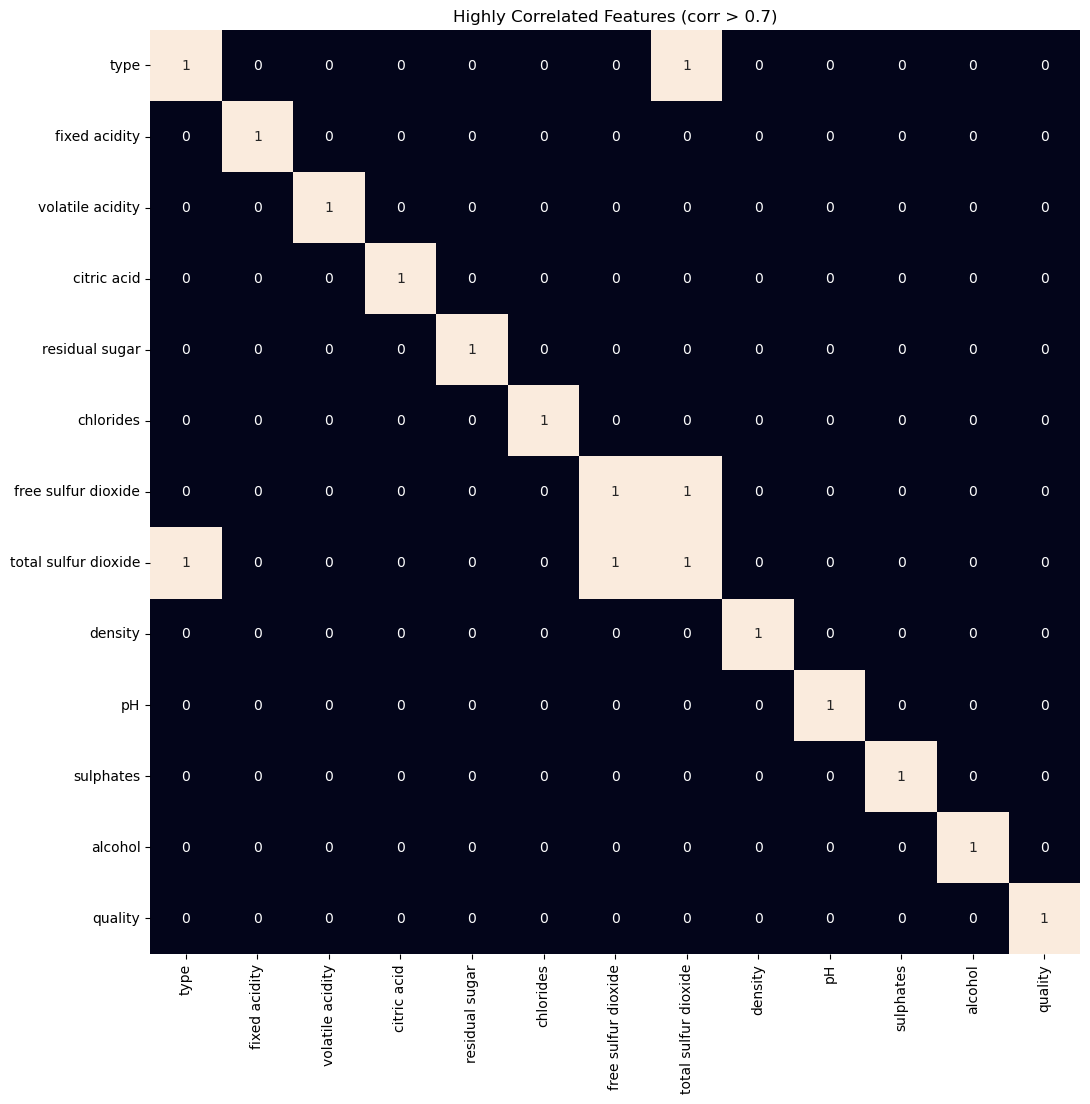


Model: LogisticRegression
 Training AUC: 0.7028
 Validation AUC: 0.6950

Model: XGBClassifier
 Training AUC: 0.9764
 Validation AUC: 0.8064

Model: SVC
 Training AUC: 0.7069
 Validation AUC: 0.6958

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       474
           1       0.85      0.88      0.87       826

    accuracy                           0.83      1300
   macro avg       0.82      0.81      0.81      1300
weighted avg       0.83      0.83      0.83      1300



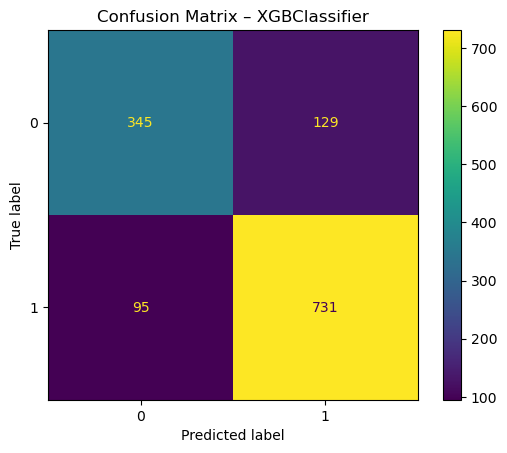

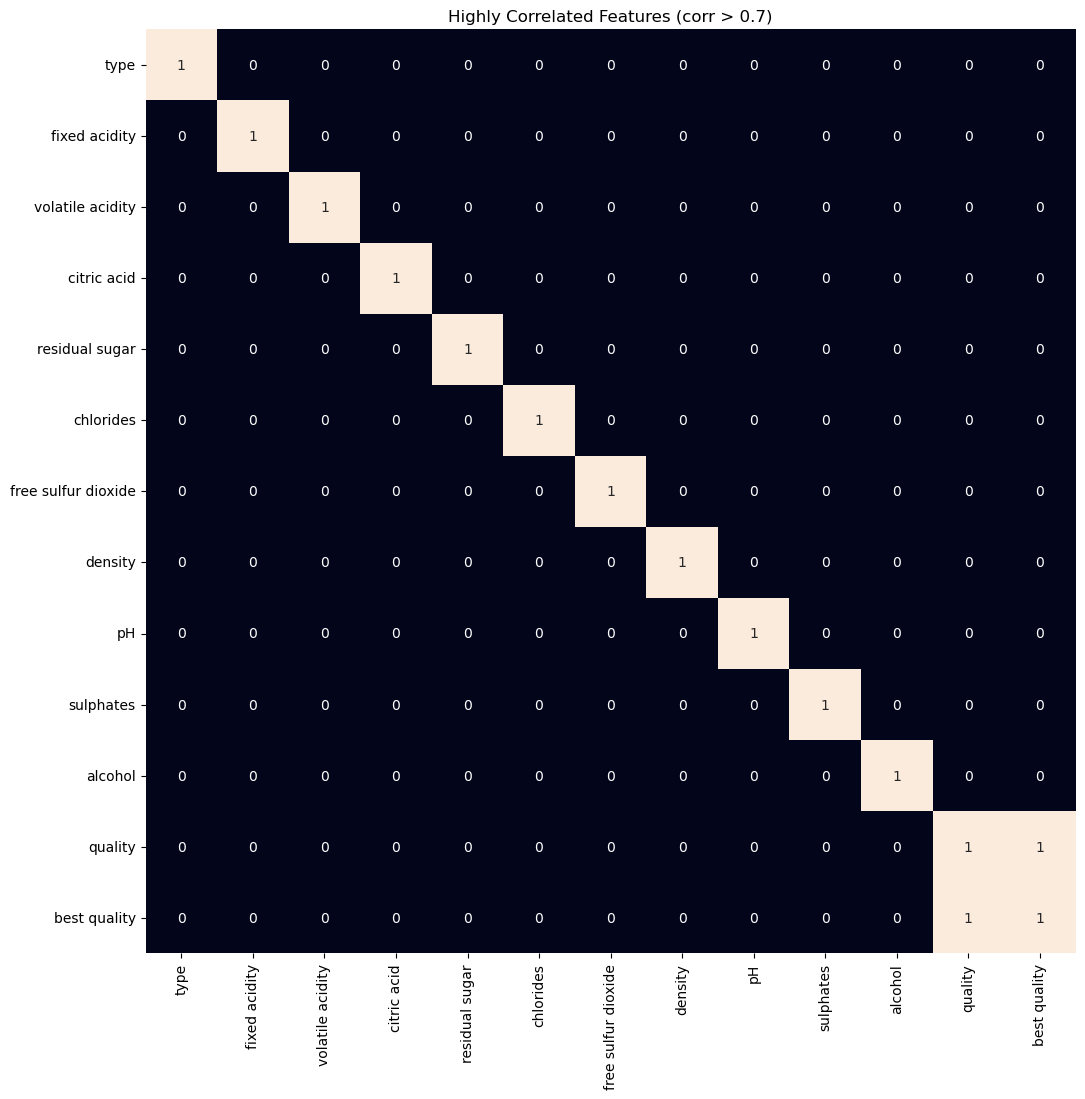

In [3]:
# wine_quality_prediction.py

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# 1. Load the dataset
df = pd.read_csv('winequalityN (1).csv')

# Encode 'type' column
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['type'] = label_encoder.fit_transform(df['type'])

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
df.info()


# 2. Exploratory Data Analysis
print("\nDescriptive statistics:")
print(df.describe().T)

print("\nMissing values per column:")
print(df.isnull().sum())

# Fill missing values with mean, if any
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mean())

# Visualization
df.hist(bins=20, figsize=(10,10))
plt.show()

plt.bar(df['quality'], df['alcohol'])
plt.xlabel('Quality')
plt.ylabel('Alcohol')
plt.show()

# Correlation heatmap to identify highly correlated features
plt.figure(figsize=(12,12))
sb.heatmap(df.corr() > 0.7, annot=True, cbar=False)
plt.title("Highly Correlated Features (corr > 0.7)")
plt.show()

# Drop 'total sulfur dioxide' if highly correlated
if 'total sulfur dioxide' in df.columns:
    df = df.drop('total sulfur dioxide', axis=1)

# 3. Create binary target ('best quality': 1 if quality > 5, else 0)
df['best quality'] = [1 if x > 5 else 0 for x in df['quality']]

# 4. Prepare features and target
features = df.drop(['quality', 'best quality'], axis=1)
target = df['best quality']

# 5. Split data into train-test sets (80:20)
xtrain, xtest, ytrain, ytest = train_test_split(
    features, target, test_size=0.2, random_state=40
)

# 6. Impute and normalize
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
xtrain = imputer.fit_transform(xtrain)
xtest = imputer.transform(xtest)

scaler = MinMaxScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# 7. Train models and compare performance
models = [
    LogisticRegression(),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    SVC(kernel='rbf')
]

for model in models:
    model.fit(xtrain, ytrain)
    train_auc = metrics.roc_auc_score(ytrain, model.predict(xtrain))
    val_auc = metrics.roc_auc_score(ytest, model.predict(xtest))
    print(f"\nModel: {model.__class__.__name__}")
    print(f" Training AUC: {train_auc:.4f}")
    print(f" Validation AUC: {val_auc:.4f}")

# 8. Evaluation (e.g., for the second model in list, XGBClassifier)
best_model = models[1]
y_pred = best_model.predict(xtest)

print("\nClassification Report:")
print(metrics.classification_report(ytest, y_pred))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(ytest, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.title(f"Confusion Matrix – {best_model.__class__.__name__}")
# Use only numeric columns for correlation heatmap
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12,12))
sb.heatmap(numeric_df.corr() > 0.7, annot=True, cbar=False)
plt.title("Highly Correlated Features (corr > 0.7)")
plt.show()

